## Example
This notebook illustrates how our system computes the final deterioration prediction for time window 24 hours.

### (1) Import relevant libraries

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import sys
import imageio
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import functional as F
import cv2
import os

sys.path.append('.')
sys.path.append('..')
from covid19_prognosis.models import gmic
from covid19_prognosis.models import gmic_drc
from utils import *


%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

### (2) Import and process chest X-rays using COVID-GMIC

In [2]:
img_files = ["../data/images/1.png",
             "../data/images/2.png"]

In [3]:
# Load all images (single channel images)
imgs = torch.cat([load_image(x).unsqueeze(0) for x in img_files], dim=0)

In [4]:
# Create model
covid_gmic_parameters = dict(device_type="cpu", 
                             image_size=(1024, 1024),
                             number_classes=4,
                             cam_size=(32, 32),
                             percent_r=0.3,
                             K=6, 
                             crop_shape=(224, 224)
                            )
device = torch.device("cpu")
covid_gmic = gmic.GMIC(covid_gmic_parameters).to(device)

In [5]:
# Load pretrained weights
weights = torch.load("../data/trained_models/covid_gmic.ckpt", map_location=torch.device('cpu'))
covid_gmic.load_state_dict(weights)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
# Forward propagation
pred = covid_gmic(imgs)
print(pred)

# Reformat x-ray predictions
pred = pred.data.cpu().numpy()
pred_windows = ['24','48','72','96']
xrays_pred = pd.DataFrame({'pred_label_24':pred[:,0], 'pred_label_48':pred[:,1],
                            'pred_label_72':pred[:,2], 'pred_label_96':pred[:,3], 
                            "Patient":[1, 2]})
cols_need = ["Patient", "label_24", "label_48", "label_72", "label_96"]
xrays_pred = xrays_pred.merge(pd.read_csv('../data/sample_xray_21102020.csv')[cols_need],
                             on="Patient", how="left")
saliency_maps = covid_gmic.saliency_map.data.cpu().numpy()

tensor([[0.0140, 0.0176, 0.0140, 0.0331],
        [0.0569, 0.0403, 0.1161, 0.1639]], grad_fn=<SigmoidBackward>)


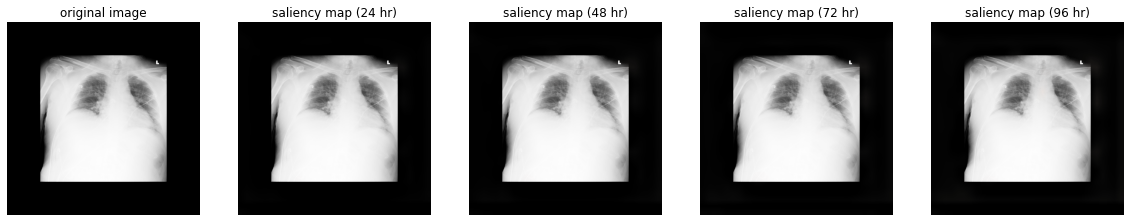

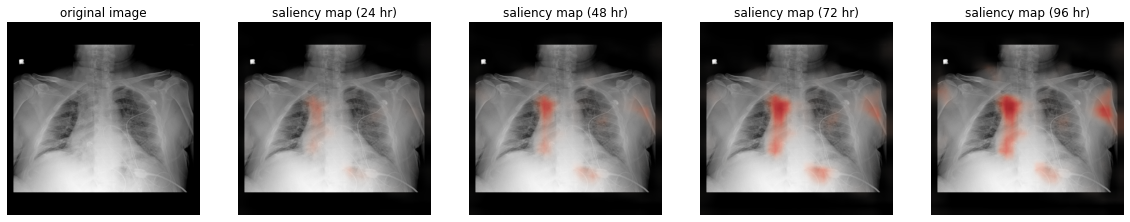

In [7]:
visualize_saliency_maps(imgs[0,0,:,:], saliency_maps[0,:,:,:])
visualize_saliency_maps(imgs[1,0,:,:], saliency_maps[1,:,:,:])

### (3) Import and process the relevant clinical variables using COVID-GBM
The clinical variables are merged based on the time of vital sign measurements, such as each set of vital sign measurements (e.g., heart rate, respiratory rate, and oxygen saturation) are linked with the statistics (minimum and  maximum) of any laboratory test results obtained prior to the time of vital sign measurements. "Patient" represents the patient admission number. 

Note that we have discarded the vital signs timestamps for anonymity purposes and are currently linking based on "Patient" in this notebook. 

In [8]:
# Upload pre-processed data 
sample_data = pd.read_csv('../data/sample_cv_21102020.csv', index_col=0)
sample_data.head()


,Patient,BMI,DBP,HR,Resp,SBP,SpO2,Temp,Weight,ALBUMIN_max_12,...,NEUTROPHILS ABSOLUTE_min_12,NEUTROPHILS %_min_12,PLATELET COUNT_min_12,POTASSIUM_min_12,PROCALCITONIN_min_12,"PROTEIN, TOTAL_min_12",SODIUM_min_12,TROPONIN I_min_12,flag.supplemental_O2,age
0,1,NaN,76.0,74.0,30.0,153.0,97.0,98.7,NaN,3.4,...,3.2,54.0,126.0,2.8,NaN,7.9,134.0,NaN,False,61.009158
1,2,35.95,46.0,67.0,30.0,147.0,92.0,99.8,200.0,3.7,...,10.3,91.0,261.0,4.1,0.06,7.0,109.0,0.02,True,66.528735


In [9]:
# Extract values based on input columns
input_cols = pkl.load(open('../data/input_columns.pkl', 'rb'))
print('The input columns are: {}'.format(input_cols))
Xtest = sample_data[input_cols].apply(pd.to_numeric, errors='coerce').fillna(0) 

The input columns are: ['age', 'BMI', 'DBP', 'HR', 'Resp', 'SBP', 'SpO2', 'Temp', 'Weight', 'ALBUMIN_max_12', 'ALT_max_12', 'AST_max_12', 'BILIRUBIN TOTAL_max_12', 'BLOOD UREA NITROGEN_max_12', 'CALCIUM_max_12', 'CHLORIDE_max_12', 'CREATININE_max_12', 'D-DIMER, QUANTITATIVE_max_12', 'EOSINOPHILS %_max_12', 'EOSINOPHILS, ABSOLUTE_max_12', 'HEMATOCRIT_max_12', 'LDH_max_12', 'LYMPHOCYTES %_max_12', 'LYMPHOCYTES ABSOLUTE_max_12', 'MEAN PLATELET VOLUME_max_12', 'NEUTROPHILS  ABSOLUTE_max_12', 'NEUTROPHILS %_max_12', 'PLATELET COUNT_max_12', 'POTASSIUM_max_12', 'PROCALCITONIN_max_12', 'PROTEIN, TOTAL_max_12', 'SODIUM_max_12', 'TROPONIN I_max_12', 'ALBUMIN_min_12', 'ALT_min_12', 'AST_min_12', 'BILIRUBIN TOTAL_min_12', 'BLOOD UREA NITROGEN_min_12', 'CALCIUM_min_12', 'CHLORIDE_min_12', 'CREATININE_min_12', 'D-DIMER, QUANTITATIVE_min_12', 'EOSINOPHILS %_min_12', 'EOSINOPHILS, ABSOLUTE_min_12', 'HEMATOCRIT_min_12', 'LDH_min_12', 'LYMPHOCYTES %_min_12', 'LYMPHOCYTES ABSOLUTE_min_12', 'MEAN PLATELE

In [10]:
for n in range(0, len(pred_windows)):
    N = pred_windows[n]
    model = pkl.load(open('../data/trained_models/XGB_model_{}.pkl'.format(N), 'rb'))
    sample_data['ehr_prob_Adv'+N] = model.predict_proba(Xtest.values)[:,1].ravel()

### (4) Combine the predictions of both models

In [11]:
test_set_fused = merge_xray_cbc(xrays_pred, sample_data, pred_windows, 120, 'ehr_prob_Adv')

['ehr_prob_Adv24', 'ehr_prob_Adv48', 'ehr_prob_Adv72', 'ehr_prob_Adv96']


In [12]:
# Mean of COVID-GBM predictions in our validation set, which are used to impute predictions in the test set if no clinical variables were collected prior to the chest X-ray
na_prob = {'24':0.41, '48':0.36, '72':0.41, '96':0.38}

# Best weights computed using our validation set to combine predictions of COVID-GMIC & COVID-GBM, such that best_weight*COVID-GMIC + (1-best_weight)*COVID-GBM 
weights = {'24':0.74, '48':0.81, '72':0.62, '96': 0.64}

for n in pred_windows:
    n = str(n)
    best_weight = weights[n]
    test_set_fused['ehr_prob_Adv'+n] = test_set_fused['ehr_prob_Adv'+n].fillna(na_prob[n])
    test_set_fused['final_pred_'+n] = best_weight*test_set_fused['pred_label_'+n] + (1-best_weight)*test_set_fused['ehr_prob_Adv'+n]


### (5) Summarize performance

In [13]:
for n in pred_windows:
    n = str(n)
    print('---------------------------------\nPrediction window {} hours'.format(n))
    summarise_results(test_set_fused, n)

---------------------------------
Prediction window 24 hours
Results using Chest X-ray only:
AUROC = 1.0
AUPRC = 1.0

Results using clinical variables only:
AUROC = 1.0
AUPRC = 1.0

Results using both modalities:
AUROC = 1.0
AUPRC = 1.0

---------------------------------
Prediction window 48 hours
Results using Chest X-ray only:
AUROC = 1.0
AUPRC = 1.0

Results using clinical variables only:
AUROC = 1.0
AUPRC = 1.0

Results using both modalities:
AUROC = 1.0
AUPRC = 1.0

---------------------------------
Prediction window 72 hours
Results using Chest X-ray only:
AUROC = 1.0
AUPRC = 1.0

Results using clinical variables only:
AUROC = 1.0
AUPRC = 1.0

Results using both modalities:
AUROC = 1.0
AUPRC = 1.0

---------------------------------
Prediction window 96 hours
Results using Chest X-ray only:
AUROC = 1.0
AUPRC = 1.0

Results using clinical variables only:
AUROC = 1.0
AUPRC = 1.0

Results using both modalities:
AUROC = 1.0
AUPRC = 1.0



### (6) Plot Deterioration Risk Curves (DRC)

In [14]:
# load all images
imgs = torch.cat([load_image(x).unsqueeze(0) for x in img_files], dim=0)
# GMIC-DRC uses image resolutions of 512 * 512
imgs = F.interpolate(imgs, (512,512))

In [15]:
# create drc model
covid_gmic_parameters = dict(device_type="cpu", 
                             image_size=(512, 512),
                            number_classes=9,
                             cam_size=(16, 16),
                             percent_r=0.2,
                            K=6, 
                            crop_shape=(224, 224),
                             feature_extractor = 'resnet34',
                             pretrained_extractor_path = None,
                             local_network = 'resnet18',
                             pretrained_local_network_path = None,
                             
                            )
device = torch.device("cpu")
covid_gmic =gmic_drc.GMIC(covid_gmic_parameters).to(device)

In [16]:
# load pretrained weights
! wget --no-check-certificate "https://nyu.box.com/shared/static/aehakobdl8t1rmw1d9hvx6emmyqj5utv.ckpt" -O './../data/trained_models/covid_gmic_drc.ckpt'
weights = torch.load("./../data/trained_models/covid_gmic_drc.ckpt", map_location=torch.device('cpu'))
covid_gmic.load_state_dict(weights)

--2020-11-02 18:46:46--  https://nyu.box.com/shared/static/aehakobdl8t1rmw1d9hvx6emmyqj5utv.ckpt
Resolving nyu.box.com (nyu.box.com)... 107.152.27.197
Connecting to nyu.box.com (nyu.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/aehakobdl8t1rmw1d9hvx6emmyqj5utv.ckpt [following]
--2020-11-02 18:46:46--  https://nyu.box.com/public/static/aehakobdl8t1rmw1d9hvx6emmyqj5utv.ckpt
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/aehakobdl8t1rmw1d9hvx6emmyqj5utv.ckpt [following]
--2020-11-02 18:46:46--  https://nyu.app.box.com/public/static/aehakobdl8t1rmw1d9hvx6emmyqj5utv.ckpt
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.27.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.27.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
# forward propagation 
pred = covid_gmic(imgs).data.cpu().numpy()

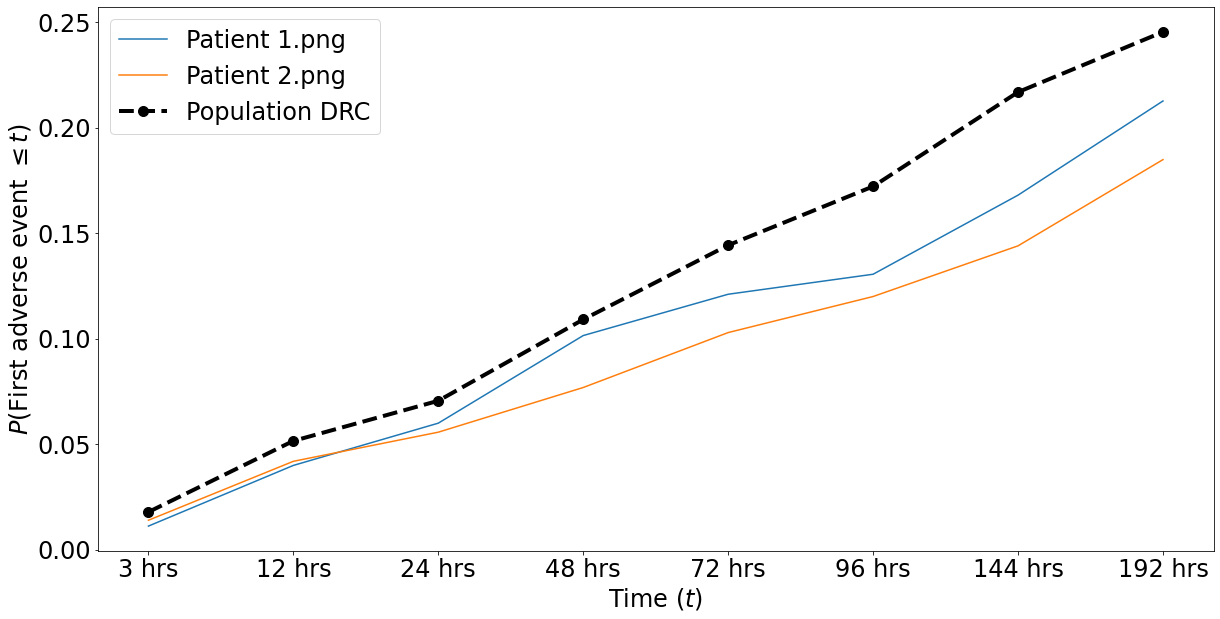

In [18]:
# plotting the drc curves
cumm_pred = np.cumprod(pred, axis=1)


# The population average is the empirically calculated DRC using our training set. 
# Empirically computed DRC for a particular time bucket = conditional probability of patient having an adverse event in that time bucket | given the patient survived the previous time bucket. 
population_average = np.array([0.017851184517851185, 0.05155155155155155, 0.07057057057057058, 0.1091091091091091,\
                               0.14431097764431097, 0.17217217217217218, 0.21688355021688355, 0.24541207874541207,\
                               0.30296963630296964])
plt.figure(figsize = (20,10))
plt.rcParams.update({'font.size': 24})
img_names = [os.path.basename(image_path) for image_path in img_files]
for i in range(cumm_pred.shape[0]):
    plt.plot(1-cumm_pred[i,:-1], label = 'Patient {}'.format(img_names[i]))
plt.plot(population_average[:-1],'o--', color = 'k', linewidth=4, ms = 10, label = "Population DRC")
plt.xticks(np.arange(8), labels = ['3 hrs','12 hrs','24 hrs','48 hrs','72 hrs','96 hrs','144 hrs','192 hrs'])
plt.legend()
plt.xlabel(r"Time ($t$)")
plt.ylabel(r"$P ($First adverse event $\leq t)$")
plt.show()